In [30]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import json
import seaborn as sns

api = wandb.Api()


In [31]:
cora_mlp=api.run("luisawerner/nesy23/21kkd3hn").summary['test_accuracies']
cora_kenn_mlp=api.run("luisawerner/nesy23/3ro8287h").summary['test_accuracies']
cora_gcn=api.run("luisawerner/nesy23/e4g0y8u0").summary['test_accuracies']
cora_kenn_gcn=api.run("luisawerner/nesy23/1agooev5").summary['test_accuracies']
cora_gat=api.run("luisawerner/nesy23/1ip2vw3v").summary['test_accuracies']
cora_kenn_gat=api.run("luisawerner/nesy23/3ob9d8s0").summary['test_accuracies']

import torch_geometric.datasets
[cora_dataset] = torch_geometric.datasets.Planetoid(root='Cora', name='Cora', split="full")
num_classes = 7
color = plt.cm.rainbow(np.linspace(0, 1, num_classes))

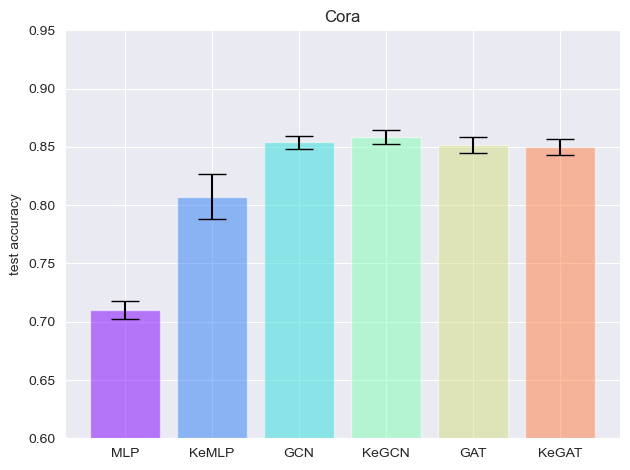

Mean Average Test Accuracy over 50 runs: 
MLP: 0.7098399999999999, KeMLP: 0.8072400000000001
GCN: 0.85382, KeGCN: 0.8586800000000001
GAT: 0.8517199999999999, KeGAT: 0.8498399999999998


p-value KeMLP > MLP for Cora: 3.9986805821323845e-55
p-value KeGCN > GCN for Cora: 3.0847335812368674e-05
p-value KeGAT > GAT for Cora: 0.9181665832178568
p-value KeGCN > KeMLP for Cora: 3.7829950148208544e-33
p-value KeGAT > KeMLP for Cora: 6.4010604845744646e-27
p-value GCN > KeMLP for Cora: 4.9784289873789096e-30
p-value GAT > KeMLP for Cora: 3.998958726481553e-28


In [32]:

xpos = np.arange(6)
cora_means = [np.mean(cora_mlp), np.mean(cora_kenn_mlp), np.mean(cora_gcn), np.mean(cora_kenn_gcn), np.mean(cora_gat), np.mean(cora_kenn_gat)]
cora_errors = [np.std(cora_mlp), np.std(cora_kenn_mlp), np.std(cora_gcn), np.std(cora_kenn_gcn), np.std(cora_gat), np.std(cora_kenn_gat)]
fig, ax = plt.subplots()
ax.bar(xpos, cora_means, yerr=cora_errors, align='center', alpha=0.5, ecolor='black', capsize=10, color=color)
ax.set_ylabel('test accuracy')
ax.set_xticks(xpos)
ax.set_xticklabels(['MLP', 'KeMLP', 'GCN', 'KeGCN', 'GAT', 'KeGAT'])
ax.set_title('Cora')
ax.yaxis.grid(True)

# Save the figure and show
plt.ylim(0.6, 0.95)
plt.tight_layout()
plt.savefig('figures/results_cora.pdf', format='pdf')
plt.show()
plt.close()

print(f'Mean Average Test Accuracy over {len(cora_mlp)} runs: ')
print(f'MLP: {np.mean(cora_mlp)}, KeMLP: {np.mean(cora_kenn_mlp)}' )
print(f'GCN: {np.mean(cora_gcn)}, KeGCN: {np.mean(cora_kenn_gcn)}' )
print(f'GAT: {np.mean(cora_gat)}, KeGAT: {np.mean(cora_kenn_gat)}' )
print ('\n')

print(f'p-value KeMLP > MLP for Cora: {scipy.stats.ttest_ind(cora_kenn_mlp, cora_mlp, alternative="greater")[1]}')
print(f'p-value KeGCN > GCN for Cora: {scipy.stats.ttest_ind(cora_kenn_gcn, cora_gcn, alternative="greater")[1]}')
print(f'p-value KeGAT > GAT for Cora: {scipy.stats.ttest_ind(cora_kenn_gat, cora_gat, alternative="greater")[1]}')
print(f'p-value KeGCN > KeMLP for Cora: {scipy.stats.ttest_ind(cora_kenn_gcn, cora_kenn_mlp, alternative="greater")[1]}')
print(f'p-value KeGAT > KeMLP for Cora: {scipy.stats.ttest_ind(cora_kenn_gat, cora_kenn_mlp, alternative="greater")[1]}')
print(f'p-value GCN > KeMLP for Cora: {scipy.stats.ttest_ind(cora_gcn, cora_kenn_mlp, alternative="greater")[1]}')
print(f'p-value GAT > KeMLP for Cora: {scipy.stats.ttest_ind(cora_gat, cora_kenn_mlp, alternative="greater")[1]}')

In [33]:
import numpy as np
def compute_compliance(data, num_classes):
    """
    compute clause compliance per iteration
    returns a list of length |number classes| with compliance value per each
    """
    # y = model.data.y.cpu().detach().numpy() do we need to detach or is this even slowing down the code?
    y = data.y.numpy()
    edge_index = np.transpose(data.edge_index.numpy())
    train_mask = data.train_mask.numpy()
    train_edge_mask = np.logical_or(train_mask[edge_index[:, 0]], train_mask[edge_index[:, 1]])

    # calculate the classes corresponding to edge index
    edge_index_cls = np.zeros_like(edge_index)
    for row in range(edge_index.shape[0]):
        edge_index_cls[row, 0] = y[edge_index[row, 0]]
        edge_index_cls[row, 1] = y[edge_index[row, 1]]

    compliance = []
    for cls in range(num_classes):
        cls_mask = np.logical_or(edge_index_cls[:, 0] == cls, edge_index_cls[:, 1] == cls)
        mask = np.logical_and(cls_mask, train_edge_mask) # edges that have at least a training node and a node of class cls
        same_mask = np.logical_and(mask, np.equal(edge_index_cls[:, 0], edge_index_cls[:, 1])) # edges that are of the above set and have the same class for both nodes
        cls_compliance = sum(same_mask)/sum(mask)
        compliance.append(cls_compliance)

    return compliance

In [34]:
print(f'Compliance Cora: {compute_compliance(cora_dataset, num_classes=num_classes)}')

Compliance Cora: [0.516, 0.657074340527578, 0.8295904887714664, 0.7107142857142857, 0.7214170692431562, 0.6339468302658486, 0.6179401993355482]


In [35]:
num_classes = 7
num_runs = 50
# for Cora
cora_keMLP = eval(api.run("luisawerner/nesy23/3ro8287h").summary['logged_clause_weights'])
cora_keGCN = eval(api.run("luisawerner/nesy23/1agooev5").summary['logged_clause_weights'])
cora_keGAT = eval(api.run("luisawerner/nesy23/3ob9d8s0").summary['logged_clause_weights'])

In [36]:
# KeMLP
num_layers = 4
# print clause weights of last epoch
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [cora_keMLP[i][layer][str(cls)][1] for i in range(num_runs)]
        print(f'Class {cls}, Layer {layer}: Mean clause weight {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')


Class 0, Layer 0: Mean clause weight 0.6018255084753037, std clause weight: 0.048160323262153776
Class 0, Layer 1: Mean clause weight 0.5451794475317001, std clause weight: 0.08394155466710988
Class 0, Layer 2: Mean clause weight 0.47305546879768373, std clause weight: 0.05241920791230282
Class 0, Layer 3: Mean clause weight 0.4539644241333008, std clause weight: 0.042772865529338226
Class 1, Layer 0: Mean clause weight 0.5507695811986923, std clause weight: 0.07738913817647067
Class 1, Layer 1: Mean clause weight 0.505237364768982, std clause weight: 0.07052322937252682
Class 1, Layer 2: Mean clause weight 0.4738943499326706, std clause weight: 0.04843193111174744
Class 1, Layer 3: Mean clause weight 0.4682398223876953, std clause weight: 0.04587087824870378
Class 2, Layer 0: Mean clause weight 0.40961839199066163, std clause weight: 0.014088333507707081
Class 2, Layer 1: Mean clause weight 0.39070788979530335, std clause weight: 0.02476803229938337
Class 2, Layer 2: Mean clause weigh

In [37]:
#KeGCN
num_layers=2
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [cora_keGCN[i][layer][str(cls)][1] for i in range(num_runs)]
        print(f'Class {cls}, Layer {layer}: Mean clause weight {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')


Class 0, Layer 0: Mean clause weight 0.4074560048803687, std clause weight: 0.26743910287067846
Class 0, Layer 1: Mean clause weight 0.4499649726226926, std clause weight: 0.24039272401789394
Class 1, Layer 0: Mean clause weight 0.4250004864111543, std clause weight: 0.2627384630870741
Class 1, Layer 1: Mean clause weight 0.4935294199921191, std clause weight: 0.23386491148327207
Class 2, Layer 0: Mean clause weight 0.4144063044153154, std clause weight: 0.2726394838712962
Class 2, Layer 1: Mean clause weight 0.3674118061736226, std clause weight: 0.2937450812480383
Class 3, Layer 0: Mean clause weight 0.37120726145920346, std clause weight: 0.29590527754886187
Class 3, Layer 1: Mean clause weight 0.3997954445704818, std clause weight: 0.3044615575144753
Class 4, Layer 0: Mean clause weight 0.42280511882156135, std clause weight: 0.2807148714677097
Class 4, Layer 1: Mean clause weight 0.41709278169786557, std clause weight: 0.26761629777951446
Class 5, Layer 0: Mean clause weight 0.490

In [38]:
#KeGAT
num_layers=1
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [cora_keGAT[i][layer][str(cls)][1] for i in range(num_runs)]
        print(f'Class {cls}, Layer {layer}: Mean clause weight {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')


Class 0, Layer 0: Mean clause weight 0.4815200024843216, std clause weight: 0.027340078000797612
Class 1, Layer 0: Mean clause weight 0.48680011451244354, std clause weight: 0.030244859801145364
Class 2, Layer 0: Mean clause weight 0.4736000084877014, std clause weight: 0.019799899261302555
Class 3, Layer 0: Mean clause weight 0.4802005606889725, std clause weight: 0.026399665435476363
Class 4, Layer 0: Mean clause weight 0.4973599475622177, std clause weight: 0.0328940924664203
Class 5, Layer 0: Mean clause weight 0.48943996489048003, std clause weight: 0.03126461744218799
Class 6, Layer 0: Mean clause weight 0.48812002420425415, std clause weight: 0.030787363278761762


Class 0, Layer 0: Mean of learned clause weight over runs: 0.39795695669949055, std clause weight: 0.24734197747736658
Class 0, Layer 1: Mean of learned clause weight over runs: 0.45002567196264864, std clause weight: 0.215392687975583
Class 1, Layer 0: Mean of learned clause weight over runs: 0.3646147803682834, std clause weight: 0.26037546613816925
Class 1, Layer 1: Mean of learned clause weight over runs: 0.44393731489777566, std clause weight: 0.21961244660728188
Class 2, Layer 0: Mean of learned clause weight over runs: 0.35692741766572, std clause weight: 0.2547894958939604
Class 2, Layer 1: Mean of learned clause weight over runs: 0.3208680287003517, std clause weight: 0.2559244180248374
Class 3, Layer 0: Mean of learned clause weight over runs: 0.2646857285918668, std clause weight: 0.24153594200657333
Class 3, Layer 1: Mean of learned clause weight over runs: 0.2946528508009396, std clause weight: 0.24700223830399287
Class 4, Layer 0: Mean of learned clause weight over runs: 

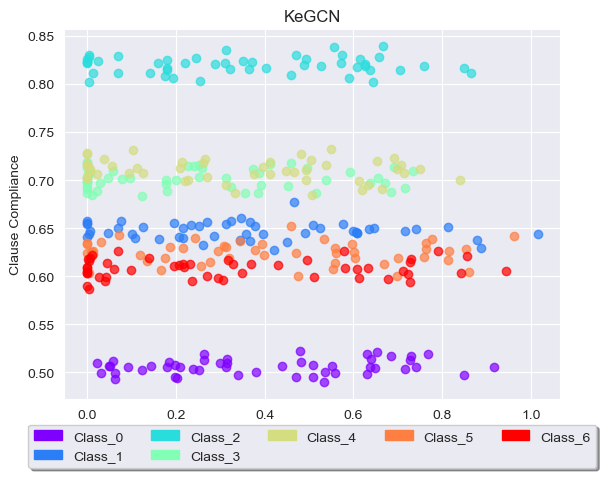

In [39]:
# KeGCN

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import json
import seaborn as sns


num_layers=2
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [cora_keGCN[i][layer][str(cls)][-1] for i in range(50)]
        print(f'Class {cls}, Layer {layer}: Mean of learned clause weight over runs: {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')

plt.figure()

cora_compliance = compute_compliance(cora_dataset, num_classes=num_classes)
print(f'Citeseer Compliance: {cora_compliance}')

patches = []
for k, j in enumerate(['0', '1', '2', '3', '4', '5', '6']):
    patches.append(mpatches.Patch(color=color[k], label='Class_'+j))
    _list = [cora_keGCN[i][0][j][-1] for i in range(50)]
    for i in _list:
        plt.scatter(i, cora_compliance[k] + np.random.normal(-0.01, 0.01)
                    , color=color[k], alpha=0.7)

plt.ylabel('Clause Compliance')
plt.xlabel('Clause Weights (over all epochs)')
#plt.legend(handles=patches)
# plt.title(f'Clause weight distribution vs. Clause Compliance, initialization = {0.5}')
plt.title('KeGCN')
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
# plt.savefig('figures/CiteSeer_KeMLP_clauseweights.pdf', format='pdf', bbox_inches = 'tight')
plt.show()


# plot clause weight evolution over epochs


Class 0, Layer 0: Mean of learned clause weight over runs: 1.0713741338253022, std clause weight: 0.21593361646885384
Class 0, Layer 1: Mean of learned clause weight over runs: 1.0804503917694093, std clause weight: 0.2549556560639286
Class 0, Layer 2: Mean of learned clause weight over runs: 0.8415245300531388, std clause weight: 0.17772609773203457
Class 0, Layer 3: Mean of learned clause weight over runs: 0.669910432100296, std clause weight: 0.11526380262127765
Class 1, Layer 0: Mean of learned clause weight over runs: 0.9342177343368531, std clause weight: 0.20559819700126558
Class 1, Layer 1: Mean of learned clause weight over runs: 0.9960800504684448, std clause weight: 0.24194533165376864
Class 1, Layer 2: Mean of learned clause weight over runs: 0.9008665865659714, std clause weight: 0.18488468587462512
Class 1, Layer 3: Mean of learned clause weight over runs: 0.8140621370077133, std clause weight: 0.15248794477877162
Class 2, Layer 0: Mean of learned clause weight over runs:

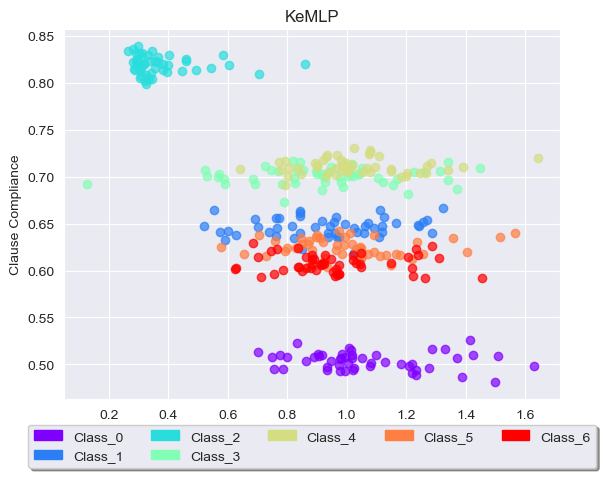

In [40]:
# KeMLP

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import json
import seaborn as sns

num_layers=4
for cls in range(num_classes):
    for layer in range(num_layers):
        cls_list = [cora_keMLP[i][layer][str(cls)][-1] for i in range(50)]
        print(f'Class {cls}, Layer {layer}: Mean of learned clause weight over runs: {np.mean(cls_list)}, std clause weight: {np.std(cls_list)}')

plt.figure()

cora_compliance = compute_compliance(cora_dataset, num_classes=num_classes)
print(f'Citeseer Compliance: {cora_compliance}')

patches = []
for k, j in enumerate(['0', '1', '2', '3', '4', '5', '6']):
    patches.append(mpatches.Patch(color=color[k], label='Class_'+j))
    _list = [cora_keMLP[i][0][j][-1] for i in range(50)]
    for i in _list:
        plt.scatter(i, cora_compliance[k] + np.random.normal(-0.01, 0.01)
                    , color=color[k], alpha=0.7)

plt.ylabel('Clause Compliance')
plt.xlabel('Clause Weights (over all epochs)')
#plt.legend(handles=patches)
# plt.title(f'Clause weight distribution vs. Clause Compliance, initialization = {0.5}')
plt.title('KeMLP')
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
# plt.savefig('figures/CiteSeer_KeMLP_clauseweights.pdf', format='pdf', bbox_inches = 'tight')
plt.show()


# plot clause weight evolution over epochs


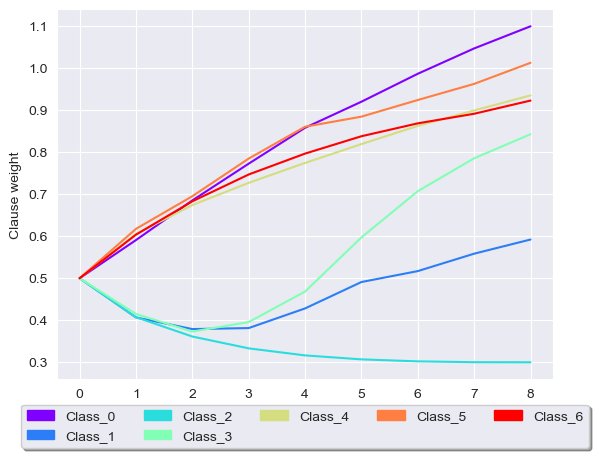

In [45]:

run = 5
#13, 16, 22
patches = []
for k, j in enumerate(['0', '1', '2', '3', '4', '5', '6']):
    patches.append(mpatches.Patch(color=color[k], label='Class_' + j))
    _list = cora_keMLP[run][0][j]
    plt.plot(_list, color=color[k])
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5)
plt.ylabel('Clause weight')
plt.xlabel('Epoch')
# plt.savefig('figures/CiteSeer_KeGCN_cw_evolution.pdf', format='pdf', bbox_inches = 'tight')
plt.show()

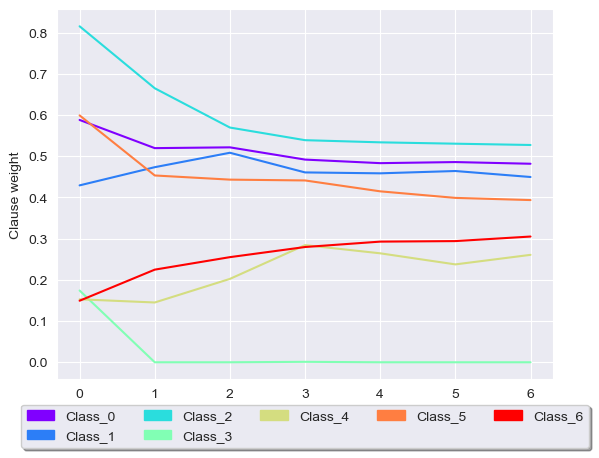

In [47]:

run = 19
#13, 16, 22
patches = []
for k, j in enumerate(['0', '1', '2', '3', '4', '5', '6']):
    patches.append(mpatches.Patch(color=color[k], label='Class_' + j))
    _list = cora_keGCN[run][0][j]
    plt.plot(_list, color=color[k])
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5)
plt.ylabel('Clause weight')
plt.xlabel('Epoch')
# plt.savefig('figures/CiteSeer_KeGCN_cw_evolution.pdf', format='pdf', bbox_inches = 'tight')
plt.show()